# Variant Calling Report v1.0
## Input Parameters

In [1]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser

pd.options.display.float_format = '{:,.2%}'.format

configFile='var_report.config'
parser = ConfigParser()
parser.read(configFile)

prmNames=['run_id',
          'h5_concordance_file', 'h5_model_file',
          'const_model', 'trained_model'
         ]

prm={}
for name in prmNames:
    prm[name]=parser.get('VarReport', name)

sources = {'Default':(prm['h5_concordance_file'],"concordance"),
           'Trained':(prm['h5_model_file'],"scored_concordance")
          }

models={'Default':prm['const_model'],
        'Trained':prm['trained_model']
       }

data = {}
for s in sources:
    data[s]={}
    d=pd.read_hdf(sources[s][0], key=sources[s][1], mode='r')
    d=d[(d['close_to_hmer_run']==False) & (d['inside_hmer_run']==False)]
    data[s]=d

pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)

,value
run_id,140185
h5_concordance_file,140185.chr9_bam.h5
h5_model_file,140185.chr9_bam.model.h5
const_model,untrained_ignore_gt_excl_hpol_runs
trained_model,threshold_model_recall_precision_ignore_gt_exc...


In [2]:
def filterByCategory(data,cat):
    if cat=='SNP':
        return data[data['indel']==False]
    elif cat=='non-hmer Indel':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>0)]
    elif cat=='hmer Indel <=4':
        return data[(data['indel']==True) & (data['hmer_indel_length']>0) & (data['hmer_indel_length']<=4)]
    elif cat=='hmer Indel >4,<12':
        return data[(data['indel']==True) & (data['hmer_indel_length']>4) & (data['hmer_indel_length']<12)]
    for i in range (1,10):
        if cat=='hmer Indel {0:d}'.format(i):
            return data[(data['indel']==True) & (data['hmer_indel_length']==i)]
    return None


In [3]:
def calcPerfomance(data, gt=False):
    classify='classify_gt' if gt else 'classify'
    
    d=data.copy()
    d['tree_score'] = np.where(d[classify]=='fn',-1,d['tree_score'])
    d=d[[classify,'tree_score']].sort_values(by=['tree_score'])
    d['label'] = np.where(d[classify]=='fp',0,1)

    num=len(d)
    numPos=sum(d['label'])
    numNeg=num-numPos
    if num<10:
        return (pd.DataFrame(),None)
    
    d['fn']=np.cumsum(d['label'])
    d['tp']=numPos-(d['fn'])
    d['fp']=numNeg-np.cumsum(1-d['label'])

    d['recall']=d['tp']/(d['tp']+d['fn'])
    d['precision']=d['tp']/(d['tp']+d['fp'])

    d['dist']=((1-d['recall'])**2+(1-d['precision'])**2)**(0.5)

    d['mask']=((d['tp']+d['fn'])>=20) & ((d['tp']+d['fp'])>=20) & (d['tree_score']>=0)
    minDist=min(d[d['mask']]['dist'])
    d['opt']=(d['dist']==minDist)

    return (d[['recall','precision']][d['mask']],
            d[['recall','precision']][d['opt']])



In [4]:
def plotPerformance(data,categories,gt=False):
    optRes={}
    for s in sources:
        optRes[s]=pd.DataFrame()

    n=len(categories)
    fig, ax = plt.subplots(1,n,figsize=(4*n,4))

    for i,cat in enumerate(categories):
        for s,c in zip(sources,('r','b')):
            d=filterByCategory(data[s],cat)
            perf,opt=calcPerfomance(d,gt)
            if not perf.empty:
                ax[i].plot(perf.recall,perf.precision,'-',label=s,color=c)    
                ax[i].plot(opt.recall,opt.precision,'o',color=c)    
            ax[i].set_title(cat)
            ax[i].set_xlabel("Recall")
            ax[i].set_xlim([0.4,1])
            ax[i].set_ylim([0.4,1])
            ax[i].grid(True)

            row=pd.DataFrame({'n':len(d),
                              'max Recall':np.nan if perf.empty else max(perf.recall),
                              'opt Recall':np.nan if perf.empty else opt.recall[0],
                              'opt Precision':np.nan if perf.empty else opt.precision[0]
                             },index=[cat])
            optRes[s]=pd.concat([optRes[s],row])

    ax[0].set_ylabel("Precision")
    ax[0].legend(loc='lower left')
    
    return optRes

## Performance: all Data

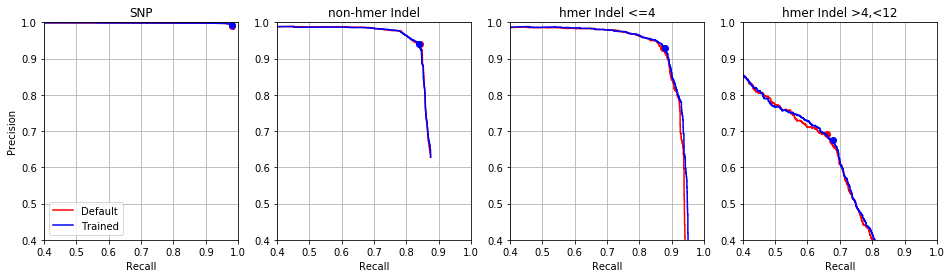

In [5]:
categories=['SNP','non-hmer Indel','hmer Indel <=4','hmer Indel >4,<12']
optRes1=plotPerformance(data,categories)


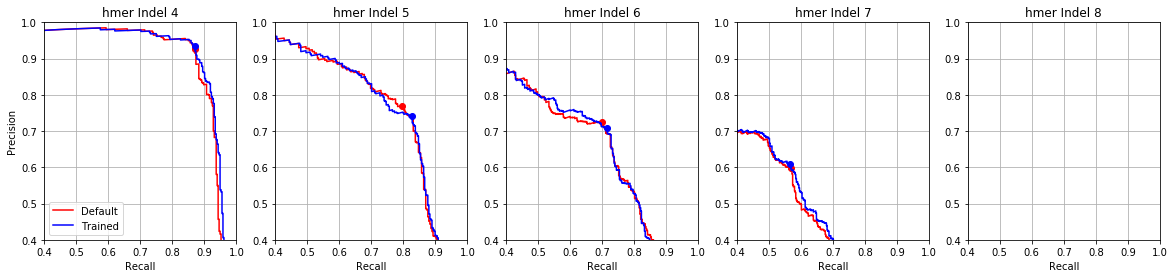

In [6]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8']
optRes2=plotPerformance(data,categories)


In [7]:
pd.options.display.float_format = '{:,.2%}'.format

optRes={}
for s in sources:
    optRes[s]=pd.concat([optRes1[s], optRes2[s]])
pd.concat([optRes[s] for s in sources], axis=1, keys=[s for s in sources])

Default                                     Trained  \
                        n max Recall opt Recall opt Precision       n   
SNP                135898     98.53%     98.18%        99.12%  135898   
non-hmer Indel      12650     87.49%     84.28%        93.94%   12650   
hmer Indel <=4     115366     97.41%     87.40%        92.79%  115366   
hmer Indel >4,<12    5043     86.32%     65.89%        69.11%    5043   
hmer Indel 4         5542     97.89%     87.05%        92.63%    5542   
hmer Indel 5         2222     94.48%     79.55%        77.04%    2222   
hmer Indel 6         1444     90.78%     69.98%        72.55%    1444   
hmer Indel 7         1377     77.73%     56.84%        59.75%    1377   
hmer Indel 8            0       nan%       nan%          nan%       0   

                                                       
                  max Recall opt Recall opt Precision  
SNP                   98.53%     98.09%        99.34%  
non-hmer Indel        87.49%     84.03%        94.05%  
hmer Indel <=4        97.41%     88.09%        93.04%  
hmer Indel >4,<12     86.32%     67.82%        67.44%  
hmer Indel 4          97.89%     87.05%        93.53%  
hmer Indel 5          94.48%     82.79%        74.13%  
hmer Indel 6          90.78%     71.39%        70.89%  
hmer Indel 7          77.73%     56.45%        60.97%  
hmer Indel 8            nan%       nan%          nan%

### Including genotype

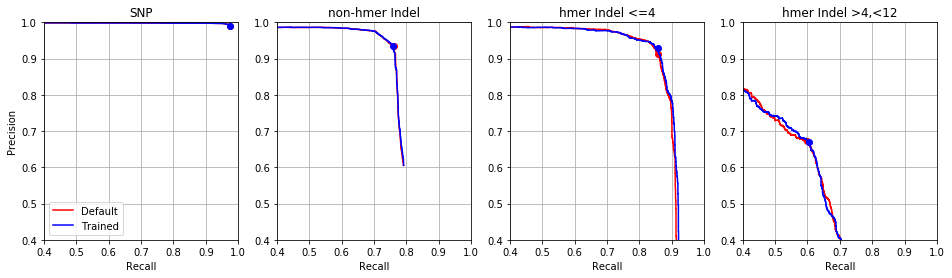

In [8]:
categories=['SNP','non-hmer Indel','hmer Indel <=4','hmer Indel >4,<12']
optRes=plotPerformance(data,categories,gt=True)


In [9]:
pd.concat([optRes[s] for s in sources], axis=1, keys=[s for s in sources])

Default                                     Trained  \
                        n max Recall opt Recall opt Precision       n   
SNP                135898     97.68%     97.40%        98.87%  135898   
non-hmer Indel      12650     79.12%     76.04%        93.35%   12650   
hmer Indel <=4     115366     94.43%     85.84%        91.37%  115366   
hmer Indel >4,<12    5043     78.45%     59.86%        67.39%    5043   

                                                       
                  max Recall opt Recall opt Precision  
SNP                   97.68%     97.36%        98.98%  
non-hmer Indel        79.12%     75.84%        93.48%  
hmer Indel <=4        94.43%     85.64%        92.90%  
hmer Indel >4,<12     78.45%     60.57%        66.99%

## Performance: cvg>=20, not-LCR, mappability.0

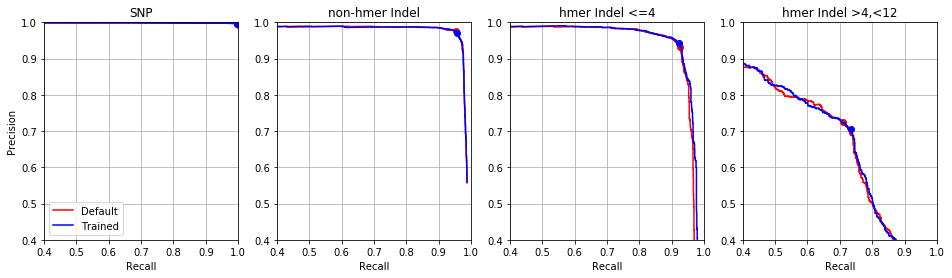

In [10]:
filtData={}
for s in sources:
    d=data[s]
    filtData[s]=d[(d['well_mapped_coverage']>=20) &
                  (~d['LCR-hs38']) & 
                  (d['mappability.0'])
                 ]

categories=['SNP','non-hmer Indel','hmer Indel <=4','hmer Indel >4,<12']

optRes1=plotPerformance(filtData,categories)


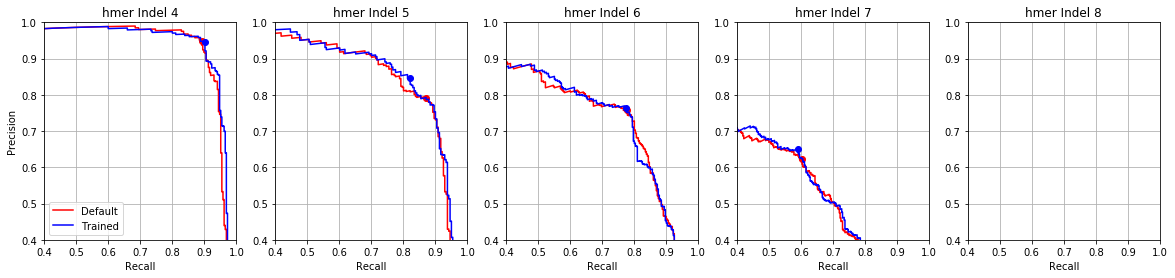

In [11]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8']
optRes2=plotPerformance(filtData,categories)

In [12]:
optRes={}
for s in sources:
    optRes[s]=pd.concat([optRes1[s], optRes2[s]])
pd.concat([optRes[s] for s in sources], axis=1, keys=[s for s in sources])

Default                                     Trained  \
                        n max Recall opt Recall opt Precision       n   
SNP                108571     99.85%     99.51%        99.55%  108571   
non-hmer Indel       7703     98.75%     95.47%        97.50%    7703   
hmer Indel <=4     103908     99.24%     92.59%        93.19%  103908   
hmer Indel >4,<12    3878     90.40%     71.09%        72.52%    3878   
hmer Indel 4         4737     98.60%     89.12%        94.78%    4737   
hmer Indel 5         1792     98.34%     87.14%        79.25%    1792   
hmer Indel 6         1073     95.64%     77.88%        75.76%    1073   
hmer Indel 7         1013     81.31%     60.35%        62.24%    1013   
hmer Indel 8            0       nan%       nan%          nan%       0   

                                                       
                  max Recall opt Recall opt Precision  
SNP                   99.85%     99.72%        99.47%  
non-hmer Indel        98.75%     95.63%        97.00%  
hmer Indel <=4        99.24%     92.42%        94.29%  
hmer Indel >4,<12     90.40%     73.49%        70.68%  
hmer Indel 4          98.60%     90.18%        94.49%  
hmer Indel 5          98.34%     82.16%        84.62%  
hmer Indel 6          95.64%     77.57%        76.38%  
hmer Indel 7          81.31%     59.09%        65.00%  
hmer Indel 8            nan%       nan%          nan%

### Including genotype

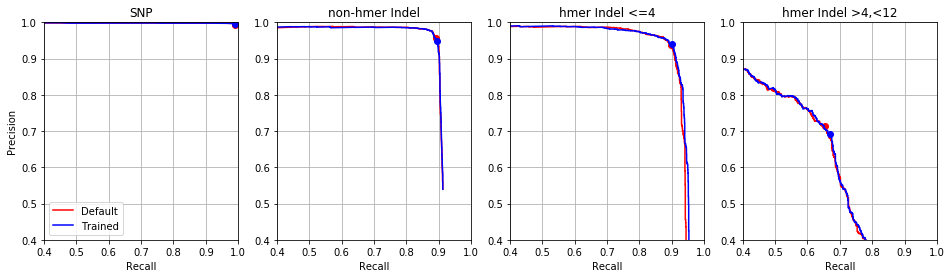

In [13]:
categories=['SNP','non-hmer Indel','hmer Indel <=4','hmer Indel >4,<12']
optRes=plotPerformance(filtData,categories,gt=True)


In [14]:
pd.concat([optRes[s] for s in sources], axis=1, keys=[s for s in sources])

Default                                     Trained  \
                        n max Recall opt Recall opt Precision       n   
SNP                108571     99.24%     99.15%        99.30%  108571   
non-hmer Indel       7703     91.27%     89.10%        95.66%    7703   
hmer Indel <=4     103908     96.68%     89.85%        93.68%  103908   
hmer Indel >4,<12    3878     82.71%     65.32%        71.38%    3878   

                                                       
                  max Recall opt Recall opt Precision  
SNP                   99.24%     99.12%        99.47%  
non-hmer Indel        91.27%     89.54%        94.88%  
hmer Indel <=4        96.68%     90.09%        94.04%  
hmer Indel >4,<12     82.71%     67.08%        69.23%